# 2D Glioma segmentation

This notebook demonstrates segmentation of brain tumors with MONAI. To accelerate training, 2D dataset is used based on the 3D one.

## Notebook structure

Here's a rough outline of this notebook:

1. Check MONAI is installed and install if not (plus any extra dependencies)
1. Import libraries
1. Set up the data (download or create)
1. Prepare for training -- create transforms, datasets, dataloaders
1. Do some quick visualisations
1. Create our model, loss function, etc.
1. Train 🎉🥳🎊
1. Check results

## Dataset

The dataset used here is the Decathlon 3D brain tumor dataset, taking the 2D slice containing the most voxels > 0 (the most label), and then saving the new dataset to disk. We'll download the pre-computed dataset from Google Drive, but the script is available in case you're interested.

<p align="center">
  <img src="https://github.com/rijobro/GliMR_MONAI_workshop/blob/main/figs/decathlon_brain_tumour_2d.png?raw=1" alt="Example of Decathlon brain tumour image">
</p>

## User input

Some sections have been left blank for you, the user, to complete. Suggested solutions are hidden in a collapsible text box. Feel free to rely on these as much as necessary, but you will get the most of the experience if you think it through or search the internet prior to displaying the results. Remember there are lots of ways of achieving the same goal, so it's OK if your solutions are different!

## Extensions

1. We have a small amount of acceleration thanks to the `CacheDataset`, can you think of any other ways to make this training faster?
1. What methods could we use to reduce overfitting? Think about transforms and our model.
1. Could you use a different model or loss function altogether? Does this give better results?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rijobro/GliMR_MONAI_workshop/blob/main/02_segmentation/01_glioma_segmentation.ipynb)

## 1. Check MONAI is installed

This checks if MONAI is installed, and if not installs it (plus any optional extras that might be needed for this notebook).

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## 2. Import libraries

In [2]:
# Copyright 2022 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tempfile
import torch
from tqdm import trange

import monai
from monai.apps import download_and_extract
from monai.data import (
    CacheDataset, DataLoader, pad_list_data_collate, decollate_batch
)
from monai.metrics import DiceMetric
from monai.networks import eval_mode
import monai.transforms as mt
from monai.utils import set_determinism
from monai.visualize.utils import blend_images

monai.config.print_config()

# Use GPU if possible, else CPU (not recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set deterministic training for reproducibility
set_determinism(seed=0)

MONAI version: 0.10.dev2230
Numpy version: 1.21.6
Pytorch version: 1.12.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7cedf254d00e68c164d3531a4d3391733bc16803
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.13.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
# figure out if we're running in Google Colab. Set paths accordingly.
try:
  import google.colab
  using_colab = True
except:
  using_colab = False

if using_colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  best_model_folder = "/content/drive/MyDrive/saved_models/"
  os.makedirs(best_model_folder, exist_ok=True)
else:
  best_model_folder = ""

best_model_path = os.path.join(best_model_folder, "best_model_2d_glioma_segmentation.pth")

Mounted at /content/drive


## 3. Setup data

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

### 2D data

We'll download the pre-computed dataset from Google Drive, but the script is available in case you're interested.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else os.path.expanduser(directory)
print(root_dir)

/tmp/tmpc5oo2ia0


In [5]:
download_from_gdrive = True
task = "Task01_BrainTumour"
output_dir = os.path.join(root_dir, task + "2D")

if download_from_gdrive:
    resource = "https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E&export=download"
    md5 = "214a338a26778c84ddebca29822add56"
    compressed_file = os.path.join(root_dir, task + "2D.tar")
    download_and_extract(resource, compressed_file, root_dir, hash_val=md5)
else:
    %run -i ../utils/2d_slice_creator.py --path {output_dir} --download_path {root_dir} --task {task}
    pass

# get all the 2d images and corresponding labels
images = sorted(glob(os.path.join(output_dir, "image_tumour", "*.nii.gz")))
labels = sorted(glob(os.path.join(output_dir, "label_tumour", "*.nii.gz")))
assert len(images) == len(labels)
data_dicts = [{"image": image, "label": label}
              for image, label in zip(images, labels)]

# shuffle the data and sort into training and validation
random.shuffle(data_dicts)
num_files = len(data_dicts)
num_train_files = round(0.8 * num_files)
train_files = data_dicts[:num_train_files]
val_files = data_dicts[num_train_files:]
print("total num files:", len(data_dicts))
print("num training files:", len(train_files))
print("num validation files:", len(val_files))

Downloading...
From: https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E&export=download
To: /tmp/tmpt3qukv3x/Task01_BrainTumour2D.tar
100%|██████████| 122M/122M [00:00<00:00, 334MB/s]

2022-07-24 19:52:55,990 - INFO - Downloaded: /tmp/tmpc5oo2ia0/Task01_BrainTumour2D.tar


2022-07-24 19:52:56,242 - INFO - Verified 'Task01_BrainTumour2D.tar', md5: 214a338a26778c84ddebca29822add56.
2022-07-24 19:52:56,246 - INFO - Writing into directory: /tmp/tmpc5oo2ia0.
total num files: 484
num training files: 387
num validation files: 97


## 4. Prepare for training -- create transforms, datasets, dataloaders

### Transforms

In terms of transforms, we first load both the image and its corresponding label. We flatten the multiple non-background segmentation classes into a single class to make this binary segmentation. We then rotate by 90 degrees, crop out superfluous zeros around the edge of the images, scale the image between 0 and 1 and then convert from numpy to pytorch.

In MONAI, we have two forms of transforms -- those that act on arrays of data, and those that act on dictionaries of data. In this case, our data is a dictionary with a key for our image and a key for our label. For the most part, we would like to apply transforms to both at the same time, so the dictionary transforms are used throughout (note the `d` suffix in our transform names).

### Datasets and dataloaders

We use the `CacheDataset` which accelerates things by pre-computing the results of our deterministic transforms. We then use a batch size of 10 in our dataloader.

In [6]:
keys = ["image", "label"]
train_transforms = val_transforms = mt.Compose(
    [
        mt.LoadImaged(keys),
        mt.Lambdad("label", lambda x: (x > 0).astype(np.float32)),  # make label binary
        mt.Rotate90d(keys),
        mt.CropForegroundd(keys, source_key="image", k_divisible=16),
        mt.ScaleIntensityd("image", channel_wise=True),
        mt.EnsureTyped(keys),
    ]
)

post_trans = mt.Compose([
    mt.Activations(sigmoid=True),
    mt.AsDiscrete(threshold=0.5),
    mt.KeepLargestConnectedComponent(applied_labels=1),
])

In [7]:
num_workers = 2
train_ds = CacheDataset(
    data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=10,
                          num_workers=num_workers, collate_fn=pad_list_data_collate)
val_ds = CacheDataset(
    data=val_files, transform=train_transforms, cache_rate=1.0, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=10,
                        num_workers=num_workers, collate_fn=pad_list_data_collate)

Loading dataset: 100%|██████████| 97/97 [00:01<00:00, 62.34it/s]


## 5. Display some examples

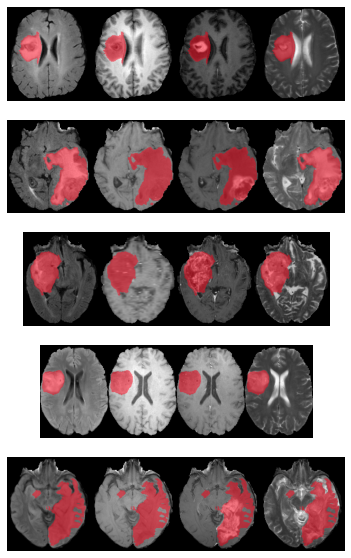

In [8]:
num_files = 5
files_to_visualize = np.random.choice(train_files, size=num_files, replace=False)
fig, axes = plt.subplots(num_files, 1, figsize=(10, 10))
for f, ax in zip(files_to_visualize, axes):
    data = train_transforms(f)
    # different modalities side by side
    img = np.concatenate(list(data["image"]), axis=1)
    lbl = np.concatenate([data["label"][0] for _ in data["image"]], axis=1)
    blended = np.moveaxis(blend_images(img[None], lbl[None]), 0, -1)
    im_show = ax.imshow(blended)
    ax.axis("off")

## 6. Create the model, loss function, etc.

### The model

Which network do you want to use? How many channels should go in and how many should come out?
<details>
  <summary>👉 Click to see an example model! 👈</summary>
  
  ```python
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)
  ```
</details>

### The loss function

Which loss function should you use? Remember that you're doing segmentation. How many channels are you dealing with? What kind of activation is needed?

<details>
  <summary>👉 Click to see an example loss function! 👈</summary>
  
  ```python
loss_function = monai.losses.DiceLoss(sigmoid=True)
  ```
</details>

In [9]:
# Insert your model here
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)
model.to(device)

# Insert your loss function here
loss_function = monai.losses.DiceLoss(sigmoid=True)

In [10]:
# Helper function for inferring during validation
def infer_seg(images, model):
    val_outputs = model(images)
    return torch.stack([post_trans(i) for i in decollate_batch(val_outputs)])


# Validation metric
dice_metric = DiceMetric(include_background=True, reduction="mean")

# use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

## 7. Train!

In [11]:
# start a typical PyTorch training
best_model_path = "best_model_2d_glioma_segmentation.pth"
max_epochs = 20
val_interval = 1
best_metric = -1
best_metric_epoch = -1
losses, metrics = [], []

tr = trange(max_epochs)
for epoch in tr:
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, labels = batch_data["image"], batch_data["label"]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(model):
            val_outputs = None
            for val_data in val_loader:
                val_images, val_labels = val_data["image"].to(
                    device), val_data["label"].to(device)
                val_outputs = infer_seg(val_images, model)
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            metrics.append(metric)
            # reset the status for next validation round
            dice_metric.reset()
            # If better than current best, save model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), best_model_path)
    tr.set_description(f"Loss: {epoch_loss:.4f}, best val metric: {best_metric:.4f} at epoch {best_metric_epoch}")

Loss: 0.1508, best val metric: 0.9133 at epoch 23:  25%|██▌       | 25/100 [02:50<08:30,  6.81s/it]


KeyboardInterrupt: ignored

In [ ]:
fig, ax = plt.subplots(facecolor='white')
ax.plot(losses, label="training loss")
ax.plot(metrics, label="validation")
ax.set_xlabel("Epoch")
_ = ax.legend()

In [ ]:
model.load_state_dict(torch.load(best_model_path))
_ = model.eval()

## 8. Check segmentations

Load validation files, apply validation transforms, infer and display!

In [ ]:
num_files = 5
files_to_visualize = np.random.choice(val_files, size=num_files, replace=False)
fig, axes = plt.subplots(num_files, 1, figsize=(10, 10))
for f, ax in zip(files_to_visualize, axes):
    data = val_transforms(f)
    inferred = infer_seg(data["image"][None].to(device), model).detach().cpu()[0]
    # average across 4 modalities. Stack side by side to compare ground truth and inferred
    avg_im = np.mean(data["image"].numpy(), axis=0, keepdims=True)
    img = np.concatenate([avg_im for _ in range(2)], axis=-1)
    lbl = np.concatenate([data["label"], inferred], axis=-1)
    blended = np.moveaxis(blend_images(img, lbl), 0, -1)
    im_show = ax.imshow(blended)
    ax.set_title("Ground truth (left) vs. inferred (right)")
    ax.axis("off")